# pm2.5 training notebook

In [44]:
import datetime as dt
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
from scipy import stats

# Functions that help me get data
import helper

## Linear & Polynomial Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。

### Load data

#### Wind speed data

In [2]:
wind_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 28)
    for day in r:
        tmp = helper.crawler(month, day)
        wind_data = wind_data + tmp

wind = pd.DataFrame(wind_data)
wind.set_index(['month', 'day', 'hour'], inplace=True)

#### Rainfall data

In [3]:
rain_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 28)
    for day in r:
        tmp = helper.crawler_rain(month, day)
        rain_data = rain_data + tmp

rain = pd.DataFrame(rain_data)
rain.set_index(['month', 'day', 'hour'], inplace=True)

#### Data from server

In [4]:
n = 1
pos = 5
data = helper.get_data_by_pos(pos)

In [5]:
df = pd.DataFrame(data)

In [6]:
df.head()

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-11 09:29:44+08:00,67,42,81,72,27
1,2019-05-11 09:44:42+08:00,67,41,82,70,27
2,2019-05-11 09:59:52+08:00,67,42,82,69,27
3,2019-05-11 10:14:42+08:00,66,38,73,62,27
4,2019-05-11 10:29:40+08:00,66,39,76,66,27


### Data preprocessing

In [7]:
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df = df.loc[ df['date'] >= start_time ]
df = df.loc[ df['date'] <= end_time ]

In [8]:
# Rename the names of columns
df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

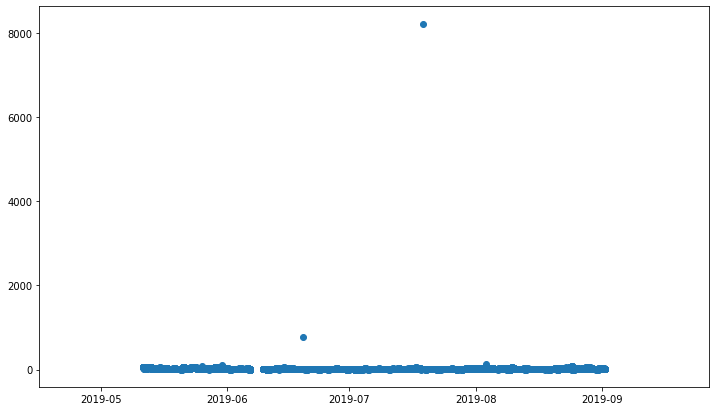

In [9]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df['date'], df['pm2.5'])

In [10]:
# Data cleaning
# want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
# df = df[(np.abs(stats.zscore(df.loc[:, want_cols])) < 7).all(axis=1)]
df = df.loc[ df['pm2.5'] <= 120 ]
df = df.loc[ df['humidity'] <= 100 ]

In [11]:
# Extra data cleaning
if pos == 3:
    time = ['2019 08 09', '2019 08 11']
    # Set time
    time1 = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    time2 = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    dftmp1 = df.loc[ df['date'] <= time1 ]
    dftmp2 = df.loc[ df['date'] >= time2 ]
    df = pd.concat([dftmp1, dftmp2])

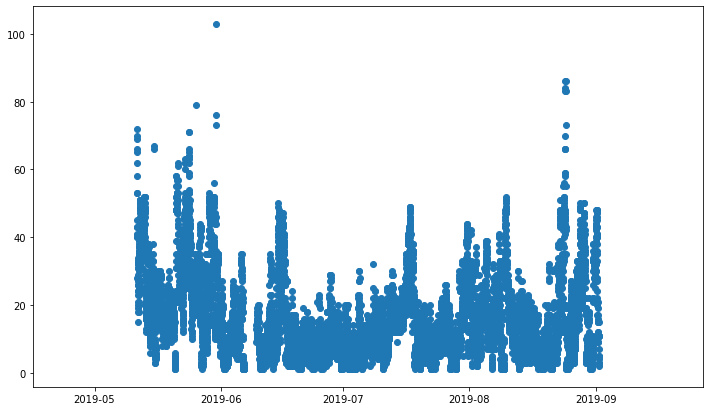

In [12]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df['date'], df['pm2.5'])

In [13]:
# Split time infomation from column `date`
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['hour'] = df['date'].apply(lambda x: x.hour)

In [14]:
# Discard some columns
df = df.drop(columns=['date'])

In [15]:
# Evaluate mean values for each hour
dfmean = df.groupby(['month', 'day', 'hour']).mean()

In [16]:
dfmean.head(10)

humidity      pm1.0     pm10.0      pm2.5   temp
month day hour                                                  
5     11  9        67.00  41.666667  81.666667  70.333333  27.00
          10       64.75  37.250000  74.500000  62.750000  27.50
          11       62.50  30.750000  63.000000  48.500000  28.00
          12       60.50  27.000000  50.000000  41.000000  29.00
          13       55.25  20.250000  31.750000  29.000000  30.25
          14       53.50  19.750000  29.750000  28.000000  31.50
          15       53.25  20.750000  34.500000  30.000000  31.75
          16       56.25  22.000000  36.750000  31.500000  30.50
          17       61.00  15.250000  23.750000  22.250000  28.00
          18       64.25  13.000000  21.250000  18.750000  26.25

In [17]:
# Create hourly time
hourly = pd.period_range(start='2019-05-11', end='2019-08-31', freq='H')
hourlydf = pd.DataFrame(hourly, columns=['time'])

In [18]:
# Split time infomation
hourlydf['month'] = hourlydf['time'].apply(lambda x: x.month)
hourlydf['day'] = hourlydf['time'].apply(lambda x: x.day)
hourlydf['hour'] = hourlydf['time'].apply(lambda x: x.hour)
# Set index
hourlydf.set_index(['month', 'day', 'hour'], inplace=True)

In [19]:
# Concat !!!!!!!!
dfconcat = pd.concat([dfmean, wind, rain], axis=1, sort=False)
# Reset index
dfconcat.reset_index(inplace=True)

In [20]:
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)

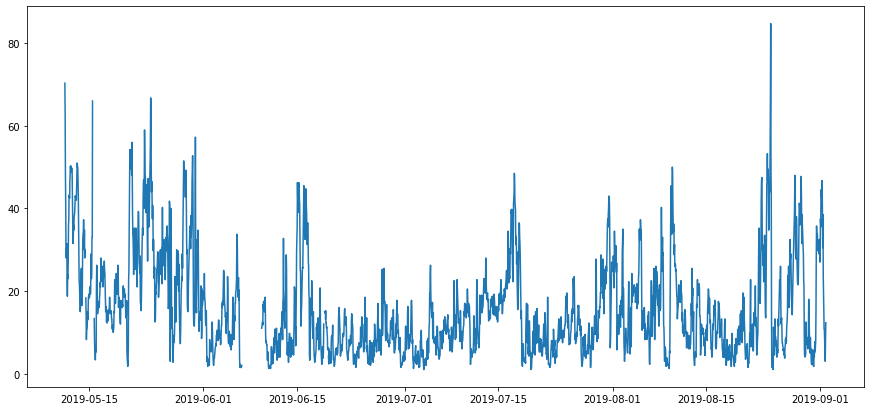

In [21]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(15, 7))
plt.plot(dfconcat['time'], dfconcat['pm2.5'])

#### Add new features

In [22]:
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-n)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-n)
dfconcat[['pm2.5_p1']] = dfconcat[['pm2.5']].shift(1)
dfconcat[['pm2.5_p2']] = dfconcat[['pm2.5']].shift(2)
dfconcat[['pm2.5_p3']] = dfconcat[['pm2.5']].shift(3)
dfconcat[['pm2.5_p4']] = dfconcat[['pm2.5']].shift(4)
dfconcat[['pm2.5_p5']] = dfconcat[['pm2.5']].shift(5)
dfconcat[['temp_p1']] = dfconcat[['temp']].shift(1)
dfconcat[['temp_p2']] = dfconcat[['temp']].shift(2)
dfconcat[['temp_p3']] = dfconcat[['temp']].shift(3)
dfconcat[['temp_p4']] = dfconcat[['temp']].shift(4)
dfconcat[['temp_p5']] = dfconcat[['temp']].shift(5)
dfconcat[['humidity_p1']] = dfconcat[['humidity']].shift(1)
dfconcat[['humidity_p2']] = dfconcat[['humidity']].shift(2)
dfconcat[['humidity_p3']] = dfconcat[['humidity']].shift(3)
dfconcat[['humidity_p4']] = dfconcat[['humidity']].shift(4)
dfconcat[['humidity_p5']] = dfconcat[['humidity']].shift(5)
dfconcat[['speed_p1']] = dfconcat[['speed']].shift(1)
dfconcat[['speed_p2']] = dfconcat[['speed']].shift(2)
dfconcat[['speed_p3']] = dfconcat[['speed']].shift(3)
dfconcat[['speed_p4']] = dfconcat[['speed']].shift(4)
dfconcat[['speed_p5']] = dfconcat[['speed']].shift(5)
dfconcat[['rain_p1']] = dfconcat[['rain']].shift(1)
dfconcat[['rain_p2']] = dfconcat[['rain']].shift(2)
dfconcat[['rain_p3']] = dfconcat[['rain']].shift(3)
dfconcat[['rain_p4']] = dfconcat[['rain']].shift(4)
dfconcat[['rain_p5']] = dfconcat[['rain']].shift(5)

In [23]:
# Polynomial terms
dfconcat['ts'] = dfconcat['temp'].apply(lambda x: x**2)
dfconcat['hs'] = dfconcat['humidity'].apply(lambda x: x**2)
dfconcat['hl'] = dfconcat['humidity'].apply(lambda x: np.sqrt(x))
dfconcat['ss'] = dfconcat['speed'].apply(lambda x: x**2)
dfconcat['rl'] = dfconcat['rain'].apply(lambda x: np.sqrt(x))

In [24]:
# Choose data every 6 row
# dfconcat = dfconcat.loc[ (dfconcat.index % 6) == 0 ]

In [25]:
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)

In [26]:
dfconcat.shape

(2482, 43)

### Feature Scaling: Normalization

$z = \frac{x- \mu}{\sigma}$


In [27]:
# Save mean and std
feature_cols = ['pm2.5', 'humidity', 'speed', 'rain', 'pm2.5_p1']
label_cols = ['pm2.5_shift']
want_cols = feature_cols + label_cols

mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all

### Divid training set and test set

In [28]:
train_size = len(dfconcat)*0.8
train_size = int(train_size)

In [29]:
train_df = dfconcat[:train_size]
test_df = dfconcat[train_size:]

### Select features

In [30]:
train_X = train_df[feature_cols]
train_y = train_df[label_cols]

In [31]:
test_X = test_df[feature_cols]
test_y = test_df[label_cols]

In [32]:
whole_X = dfconcat[feature_cols]
whole_y = dfconcat[label_cols]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [33]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [34]:
# See the coefficients of our model
for i in range(len(train_X.columns)):
    print('Coefficient for %10s:\t%s' % (train_X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for      pm2.5:	1.0633874394006586
Coefficient for   humidity:	-0.023088712870919088
Coefficient for      speed:	-0.052201928845604595
Coefficient for       rain:	0.002489845957005444
Coefficient for   pm2.5_p1:	-0.14421996243600751
Intercept: 			 -0.008142302971985243


In [35]:
# Calculate predict value
predict_train_y = model.predict(train_X)
predict_test_y = model.predict(test_X)

In [36]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_test_y_ori = predict_test_y * s + m

train_y_ori = train_y * s + m
predict_train_y_ori = predict_train_y * s + m

# m = mean_all['pm2.5']
# s = std_all['pm2.5']

# test_df_ori = test_df['pm2.5'] * s + m

### Assessing the Fit of the Model

In [37]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(train_y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_test_y_ori)

train_mape = mean_absolute_percentage_error(train_y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_test_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 14.785134,	 RMSE: 3.845144 (μg/m^3),	 MAPE:	 23.773550 %
Test MSE:	 18.881360,	 RMSE: 4.345269 (μg/m^3),	 MAPE:	 27.315325 %


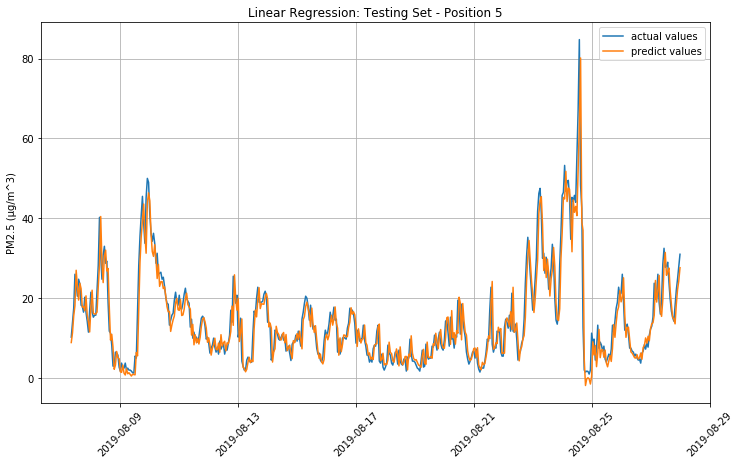

In [38]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_test_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper right')
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

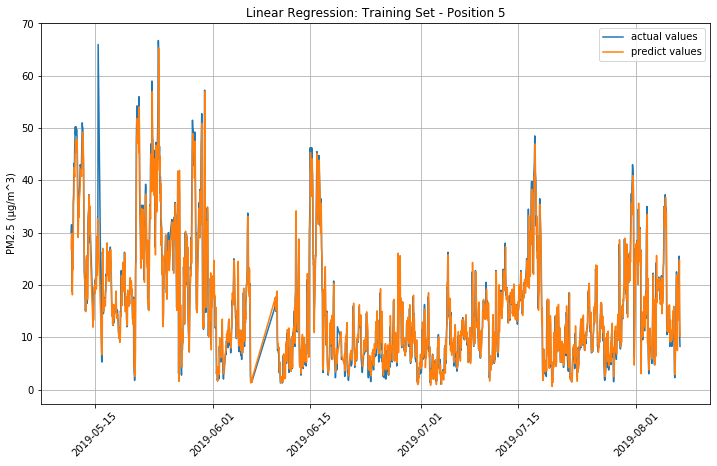

In [39]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(train_df['time_shift'], train_y_ori, label='actual values')
plt.plot(train_df['time_shift'], predict_train_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper right')
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()

In [40]:
from sklearn.model_selection import learning_curve

def plt_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

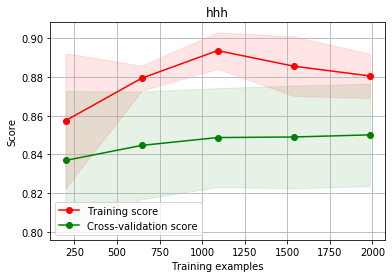

In [41]:
plt_learning_curve(estimator=model, title='hhh', X=whole_X, y=whole_y,
                   ylim=None, cv=5, n_jobs=None)

### Feature Selection via Ridge Regression

~~Our test error is worse than our training error. Therefore, our next job is to improve this.~~

Next, we improve mean squared error. 

We use the class `sklearn.linear_model.Ridge`. We will throw all features in, let ridge regression do selection, and see how our own feature sets compare. Notice we have an additional hyperparameter,  𝛼 . This controls how heavy the penalty is for larger weights.

To perform hyperparameter tuning we can use a technique called **cross validation**. We take our test set, randomly divide into  𝑘  training and testing sets. Differnent samples will be randomly placed in each set, each with their own variance. We then average the results over the folds to estimate how well we will do on unseen test data. After splitting the data into  𝑘  folds (10 is a usual choice for  𝑘 ), we will try out different hyperparameter values and select the best one. Much of this process is already wrapped in `sklearn.model_selection.cross_val_score` for us. We just need to define a scoring function.


In [42]:
# Define a scoring function
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [45]:
# Define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=100, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, train_X, train_y, cv=10, scoring=scorer)
    mses.append(mse.mean())

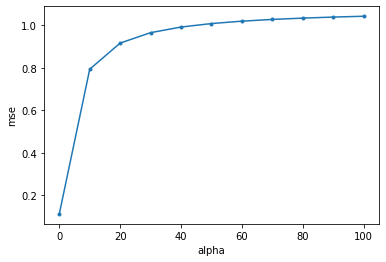

In [46]:
plt.plot(alphas, mses, marker='.')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [47]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [48]:
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(train_X, train_y)

Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [49]:
# See the coefficients of our model
for i in range(len(train_X.columns)):
    print('Coefficient for %10s:\t%s' % (train_X.columns[i], ridge.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for      pm2.5:	1.0633874394006542
Coefficient for   humidity:	-0.023088712870919004
Coefficient for      speed:	-0.052201928845604595
Coefficient for       rain:	0.0024898459570056545
Coefficient for   pm2.5_p1:	-0.14421996243600255
Intercept: 			 -0.008142302971985243


In [50]:
# Calculate mean squared error for training set & test set
predict_train_y = ridge.predict(train_X)
predict_test_y = ridge.predict(test_X)

In [51]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_test_y_ori = predict_test_y * s + m

train_y_ori = train_y * s + m
predict_train_y_ori = predict_train_y * s + m

# m = mean_all['pm2.5']
# s = std_all['pm2.5']

# test_df_ori = test_df['pm2.5'] * s + m

In [52]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(train_y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_test_y_ori)

train_mape = mean_absolute_percentage_error(train_y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_test_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 14.785134,	 RMSE: 3.845144 (μg/m^3),	 MAPE:	 23.773550 %
Test MSE:	 18.881360,	 RMSE: 4.345269 (μg/m^3),	 MAPE:	 27.315325 %


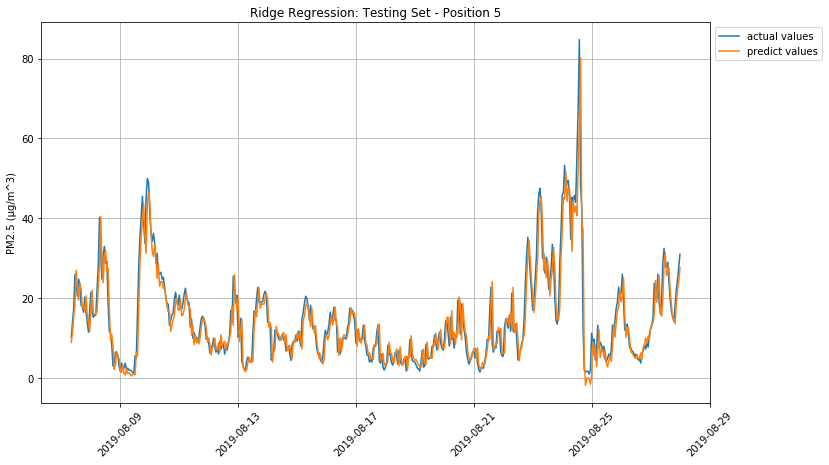

In [53]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_test_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Ridge Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

## Input all positions data

In [54]:
for i in range(0, 8):    
    # Load data
    n=1
    pos=i
    data = helper.get_data_by_pos(pos)
    df = pd.DataFrame(data)
    # Input time
    if pos == 2:
        time = ['2019 06 06', '2020 01 01']
    else:
        time = ['2019 05 11', '2020 01 01']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    df = df.loc[ df['date'] >= start_time ]
    df = df.loc[ df['date'] <= end_time ]
    # Rename the names of columns
    df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Data cleaning
    df = df.loc[ df['pm2.5'] <= 120 ]
    df = df.loc[ df['humidity'] <= 100 ]
    # Extra data cleaning
    if pos == 3:
        time = ['2019 08 09', '2019 08 11']
        # Set time
        time1 = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
        time2 = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
        # Select the duration
        dftmp1 = df.loc[ df['date'] <= time1 ]
        dftmp2 = df.loc[ df['date'] >= time2 ]
        df = pd.concat([dftmp1, dftmp2])
    # Split time infomation from column `date`
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['hour'] = df['date'].apply(lambda x: x.hour)
    # Discard some columns
    df = df.drop(columns=['date'])
    # Evaluate mean values for each hour
    dfmean = df.groupby(['month', 'day', 'hour']).mean()
    # Concat !!!!!!!!
    dfconcat = pd.concat([dfmean, wind, rain], axis=1, sort=False)
    # Reset index
    dfconcat.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`

    def get_time(x):
        time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
        taipei_tz = pytz.timezone('Asia/Taipei')
        time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
        return time

    dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
    # Add new feature
    # Add position
    dfconcat['position'] = pos
    # Shift columns
    dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-n)
    dfconcat[['time_shift']] = dfconcat[['time']].shift(-n)
    dfconcat[['pm2.5_p1']] = dfconcat[['pm2.5']].shift(1)
    dfconcat[['pm2.5_p2']] = dfconcat[['pm2.5']].shift(2)
    dfconcat[['pm2.5_p3']] = dfconcat[['pm2.5']].shift(3)
    dfconcat[['pm2.5_p4']] = dfconcat[['pm2.5']].shift(4)
    dfconcat[['pm2.5_p5']] = dfconcat[['pm2.5']].shift(5)
    # Polynomial terms
    dfconcat['ts'] = dfconcat['temp'].apply(lambda x: x**2)
    dfconcat['hs'] = dfconcat['humidity'].apply(lambda x: x**2)
    dfconcat['hl'] = dfconcat['humidity'].apply(lambda x: np.sqrt(x))
    dfconcat['ss'] = dfconcat['speed'].apply(lambda x: x**2)
    dfconcat['rl'] = dfconcat['rain'].apply(lambda x: np.sqrt(x))
    #
    if i == 0:
        result = dfconcat
    else:
        result = pd.concat([result, dfconcat])

dfconcat = result

In [55]:
dum = pd.get_dummies(dfconcat['position'], prefix='position')
dfconcat = pd.concat([dfconcat, dum], axis=1, sort=False)

In [56]:
dfconcat.set_index(['month', 'day', 'hour', 'position'], inplace=True)
dfconcat.reset_index(inplace=True)

In [57]:
pd.set_option('display.max_columns', None)
dfconcat.tail()

,month,day,hour,position,humidity,pm1.0,pm10.0,pm2.5,temp,speed,rain,time,pm2.5_shift,time_shift,pm2.5_p1,pm2.5_p2,pm2.5_p3,pm2.5_p4,pm2.5_p5,ts,hs,hl,ss,rl,position_0,position_1,position_2,position_3,position_4,position_5,position_6,position_7
21775,9,1,15,7,58.250000,11.000000,12.250000,12.250000,30.0,NaN,NaN,2019-09-01 14:54:00+08:00,12.000000,2019-09-01 15:54:00+08:00,15.25,16.50,20.50,23.25,32.25,900.00,3393.062500,7.632169,NaN,NaN,0,0,0,0,0,0,0,1
21776,9,1,16,7,60.750000,10.000000,12.000000,12.000000,30.0,NaN,NaN,2019-09-01 15:54:00+08:00,5.750000,2019-09-01 16:54:00+08:00,12.25,15.25,16.50,20.50,23.25,900.00,3690.562500,7.794229,NaN,NaN,0,0,0,0,0,0,0,1
21777,9,1,17,7,61.000000,4.500000,5.750000,5.750000,28.5,NaN,NaN,2019-09-01 16:54:00+08:00,5.250000,2019-09-01 17:54:00+08:00,12.00,12.25,15.25,16.50,20.50,812.25,3721.000000,7.810250,NaN,NaN,0,0,0,0,0,0,0,1
21778,9,1,18,7,64.750000,4.250000,5.500000,5.250000,27.5,NaN,NaN,2019-09-01 17:54:00+08:00,11.333333,2019-09-01 18:54:00+08:00,5.75,12.00,12.25,15.25,16.50,756.25,4192.562500,8.046738,NaN,NaN,0,0,0,0,0,0,0,1
21779,9,1,19,7,66.666667,10.333333,11.333333,11.333333,28.0,NaN,NaN,2019-09-01 18:54:00+08:00,NaN,NaT,5.25,5.75,12.00,12.25,15.25,784.00,4444.444444,8.164966,NaN,NaN,0,0,0,0,0,0,0,1


In [58]:
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)

In [59]:
# Save mean and std
cat_cols = ['position_0', 'position_1', 'position_2', 'position_3',
            'position_4', 'position_5', 'position_6', 'position_7']
cal_cols = ['pm2.5', 'humidity', 'speed', 'rain', 'pm2.5_p1']
label_cols = ['pm2.5_shift']
feature_cols = cal_cols
want_cols = cal_cols + label_cols

mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
train_size = len(dfconcat)*0.8
train_size = int(train_size)

train_df = dfconcat[:train_size]
test_df = dfconcat[train_size:]
# Select feature
X = train_df[feature_cols]
y = train_df[label_cols]

test_X = test_df[feature_cols]
test_y = test_df[label_cols]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

#m = mean_all['pm2.5']
#s = std_all['pm2.5']

#test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Coefficient for      pm2.5:	1.0074621178626673
Coefficient for   humidity:	-0.006528615264225104
Coefficient for      speed:	-0.045461195342011804
Coefficient for       rain:	-0.014461864671892819
Coefficient for   pm2.5_p1:	-0.09369052530897853
Intercept: 			 -0.00023649475448603383
Train MSE:	 17.312320,	 RMSE: 4.160808 (μg/m^3),	 MAPE:	 26.615642 %
Test MSE:	 18.342148,	 RMSE: 4.282773 (μg/m^3),	 MAPE:	 28.447812 %


In [60]:
test_df['predict_y_ori'] = predict_y_ori
test_df['test_y_ori'] = test_y_ori
train_df['y_ori'] = y_ori
train_df['predict_train_y_ori'] = predict_train_y_ori

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [61]:
# Select the duration
pos = 7
test_df3 = test_df.loc[ test_df['position'] == pos ]
train_df3 = train_df.loc[ train_df['position'] == pos ]

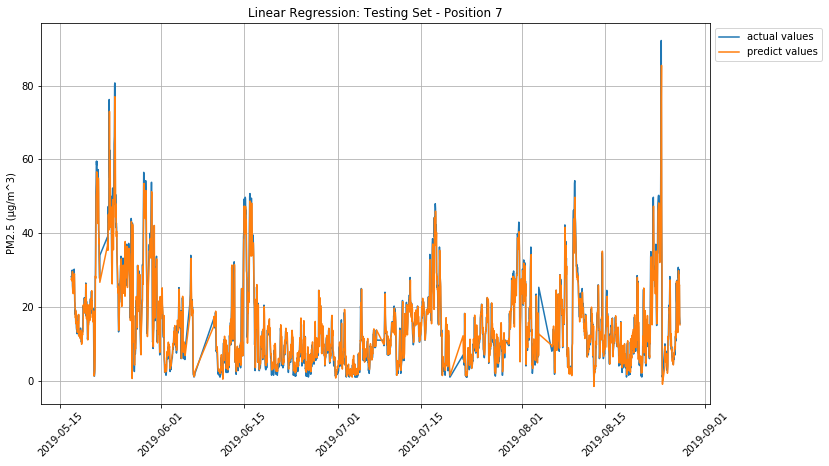

In [62]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df3['time'], test_df_ori, label='actual values')
plt.plot(test_df3['time_shift'], test_df3['test_y_ori'], label='actual values')
plt.plot(test_df3['time_shift'], test_df3['predict_y_ori'], label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

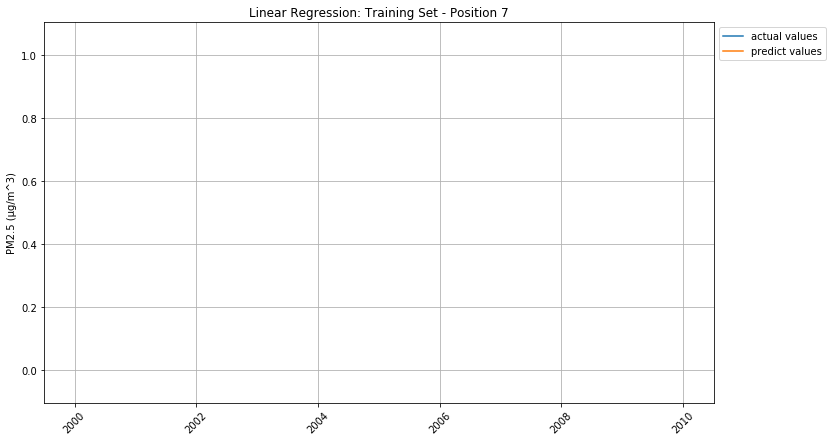

In [63]:
# Plt
plt.figure(figsize=(12, 7))
plt.plot(train_df3['time_shift'], train_df3['y_ori'], label='actual values')
plt.plot(train_df3['time_shift'], train_df3['predict_train_y_ori'], label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()